In [1]:
%matplotlib inline

from pathlib import Path

import numpy as np
import pandas as pd
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.model_selection import train_test_split

In [2]:
from sklearn.linear_model import LogisticRegression

import matplotlib.pylab as plt
import seaborn as sns
from dmba import classificationSummary, gainsChart, liftChart
from dmba.metric import AIC_score

In [3]:
!pip install mord

In [4]:
import statsmodels.api as sm
from mord import LogisticIT # No module named 'mord'

## 10.1 은행 재정상태

In [98]:
bank = pd.read_csv('Banks.csv')

In [6]:
bank.drop(columns=['Obs', 'TotCap/Assets'], inplace=True)

# 'TotExp/Assets' : 총 자산 대비 총 비용의 비율
# 'TotLns&Lses/Assets' : 총 자산 대비 대출과 리스트의 총합인 비율
# 결과 변수 > 'Financial Condition' : 은행의 재정 상태 (재정적으로 약함-1, 강함-0)

In [7]:
bank.columns

Index(['Financial Condition', 'TotExp/Assets', 'TotLns&Lses/Assets'], dtype='object')

In [8]:
bank.columns = [c.replace(' ', '_') for c in bank.columns]

In [9]:
predictors = ['TotExp/Assets', 'TotLns&Lses/Assets']
outcome = 'Financial_Condition'

y = bank[outcome]
X = bank[predictors]

# fit a logistic regression (set penalty=l2 and C=1e42 to avoid regularization)
logit_reg = LogisticRegression(penalty="l2", C=1e42, solver='liblinear')
logit_reg.fit(X, y) ## 회귀식을 도출해야 함

print('intercept', logit_reg.intercept_[0])
print(pd.DataFrame({'coef': logit_reg.coef_[0]}, index=X.columns.transpose()))

intercept -14.720832806179038
                         coef
TotExp/Assets       89.832567
TotLns&Lses/Assets   8.371267


In [10]:
b0=round(-14.720832806179038,4)
b1=round(89.832567,4)
b2=round(8.371267,4)

#### a

In [11]:
print(b0,'\t', b1,'\t', b2)

-14.7208 	 89.8326 	 8.3713


In [12]:
### 1 ### 로짓 사용

log(Odds) = -14.7208+ 89.8326 *x1 +  8.3713*x2

In [13]:
### 2 ### 오즈 사용

Odds(Y=1)=e^(-14.7208+ 89.8326 x1 + 8.3713x2)

In [14]:
### 3 ### 확률 사용

p=0dds/(Odds+1)

#### b

In [15]:
# TotLns&Lses/Assets = 0.6
# TotExp/Assets = 0.11 -> 새로운 은행 고려

In [16]:
### 1 ### 로짓 사용

In [17]:
log_Odds = -14.7208+ 89.8326*0.11 + 8.3713*0.6
log_Odds=round(log_Odds,4)
log_Odds

0.1836

In [18]:
### 2 ### 오즈 사용

In [19]:
import math

In [20]:
Odds_Y_1=math.exp(log_Odds)
Odds_Y_1=round(Odds_Y_1,4)
Odds_Y_1

1.2015

In [21]:
### 3 ### 확률 사용, 컷오프 값 0.5 사용

In [22]:
p=Odds_Y_1/(Odds_Y_1+1)
p=round(p,4)
p 

0.5458

p= 0.54583이며 컷오프값인 0.5보다 크기 때문에 재정적으로 약하다(1)에 분류한다.

// 컷오프값보다 크면 1에 분류

#### c

In [23]:
# 컷오프값 0.5는 재정적으로 약할 확률 (Y=1)

In [24]:
#오즈의 임계값

그래프를 통해 오즈가 0에 수렴

In [25]:
#해당 로짓에 대한 임계값

양, 음의 무한대로 발산 -> 수렴하지 않는다.

#### d

In [26]:
# TotLns&Lses/Assets 회귀계수의 추정치 해석

In [27]:
b2

8.3713

양의 회귀계수는 그 예측변수 값이 클수록 재정적으로 약할 확률이 높음을 의미한다. #p265 참고

#### e

재정이 열악한 은행을 재정상태가 좋다고 오분류한 경우의 (비용) 
###### >

재정이 튼튼한 은행을 재정이 약하다고 오분류한 경우의 비용

In [28]:
classificationSummary(y, logit_reg.predict(X))

Confusion Matrix (Accuracy 0.9000)

       Prediction
Actual 0 1
     0 9 1
     1 1 9


1/10 값을 감소해야 함

In [29]:
## 분류 성능 평가 - 5장 표5.5
## 비용이 큰 것을 감소하기 위해 재정이 열악하다고 의미하는 것에 있어서(y=1) 에 대해 컷오프값 감소

## 10.2 올바른 시스템 관리자 식별

In [30]:
sys = pd.read_csv('SystemAdministrators.csv')

In [31]:
sys.columns ## 경험과 교육

Index(['Experience', 'Training', 'Completed task'], dtype='object')

In [32]:
sys.head(5)

,Experience,Training,Completed task
0,10.9,4,Yes
1,9.9,4,Yes
2,10.4,6,Yes
3,13.7,6,Yes
4,9.4,8,Yes


#### a

In [33]:
import pandas as pd
from pandas.plotting import scatter_matrix, parallel_coordinates

In [34]:
sys2 = pd.get_dummies(sys['Completed task'])
sys2.head(5)

,No,Yes
0,0,1
1,0,1
2,0,1
3,0,1
4,0,1


<AxesSubplot:xlabel='Experience', ylabel='Completed task'>

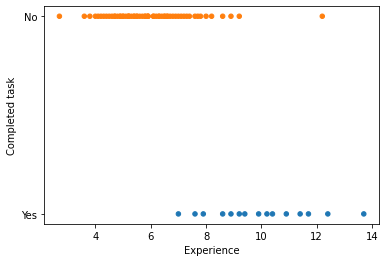

In [35]:
sys.plot.scatter(x='Experience', y='Completed task', color=['C0' if color == 1 else 'C1'for color in sys2.Yes])

## 아래 산점도를 보면 비교적으로 정확하게 구별되는 것을 확인해 볼 수 있다?

#### b

In [36]:
predictors = ['Experience', 'Training']
outcome = 'Completed task'

y = sys[outcome]
X = sys[predictors]

train_X, valid_X, train_y, valid_y = train_test_split(X, y, test_size=0.4, random_state=1)

# fit a logistic regression (set penalty=l2 and C=1e42 to avoid regularization)
logit_reg = LogisticRegression(penalty="l2", C=1e42, solver='liblinear')
logit_reg.fit(train_X, train_y)

LogisticRegression(C=1e+42, solver='liblinear')

In [37]:
classificationSummary(train_y, logit_reg.predict(train_X))

Confusion Matrix (Accuracy 0.9111)

       Prediction
Actual  0  1
     0 31  1
     1  3 10


업무를 완료한 관리자들 중 업무를 완료하지 못한 것으로 잘못 분류된 관리자의 비율
= 3/13

#### c

b의 확률을 감소하기 위해서 분자의 값이 작아지고 분모가 커져야 한다.
따라서 0으로 오분류하는 경우를 감소하기 위해 컷오프값을 감소

###### 5장 예측성능 평가 표 5.5 참고

#### d

In [38]:
# 업무 추정 확률이 0.5 초과를 위해 - b번에서 데이터세트를 학습데이터로 사용했기에 이를 그대로 적용하여 풀이

In [39]:
print('intercept', logit_reg.intercept_[0])
print(pd.DataFrame({'coef': logit_reg.coef_[0]}, index=X.columns.transpose()))

intercept -15.646119443605366
                coef
Experience  1.835234
Training    0.118728


In [40]:
b0=round(-15.646119443605366,4)
b1=round(1.835234,4) ## experience
b2=round(0.118728,4) ## training
print(b0,'\t', b1,'\t', b2)

-15.6461 	 1.8352 	 0.1187


log__Odds = -15.6461 + 1.8352 *x1 + 0.1187*x2

Odds_Y_1=math.exp(log__Odds)

p=Odds_Y_1/(Odds_Y_1+1)

In [41]:
# p>0.5

# 오즈가 1보다 커야 함
# 로짓이 0보다 커야 함 

In [42]:
train_X=train_X[train_X['Training']==4]
train_X.head()

,Experience,Training
57,5.1,4
48,6.1,4
61,8.0,4
45,7.8,4
24,8.9,4


In [43]:
log_Odds2 = -15.6461 + 1.8352*train_X.Experience + 0.1187*4
log_Odds2 =round(log_Odds2,4)
log_Odds2.sort_index(ascending=True)

0      4.8324
1      2.9972
5      7.5852
7      1.1620
9      5.7500
11     1.7125
13    -1.2238
14    -2.3249
17    -5.9953
18    -6.3623
20    -7.4635
22    -6.5459
23    -5.6283
24     1.1620
28    -1.0403
29   -10.2163
30    -2.8755
37    -1.2238
41    -3.9766
45    -0.8567
46    -2.3249
48    -3.9766
49    -6.1788
50    -2.5084
51    -5.6283
57    -5.8118
61    -0.4897
62    -7.8305
63    -3.6095
64    -3.0590
67    -3.2425
69    -4.3436
74    -5.4447
Name: Experience, dtype: float64

In [44]:
# 로짓이 0보다 커야한다고 했기 때문에 최소로 갖는 양수값은 인덱스가 7일 때이다.

In [45]:
train_X.sort_index(ascending=True).iloc[0:6] ## 양수값을 갖는 부분을 다 보임

,Experience,Training
0,10.9,4
1,9.9,4
5,12.4,4
7,8.9,4
9,11.4,4
11,9.2,4


따라서 경험이 적어도 8.9개월은 되어야 업무완료의 추정 확률이 50퍼센트를 초과할 수 있다.

## 10.3 승차식 잔디깎이 기계의 판매

In [46]:
rm = pd.read_csv('RidingMowers.csv')

In [47]:
rm.head(5)

,Income,Lot_Size,Ownership
0,60.0,18.4,Owner
1,85.5,16.8,Owner
2,64.8,21.6,Owner
3,61.5,20.8,Owner
4,87.0,23.6,Owner


#### a

In [48]:
print(rm[rm['Ownership']=='Owner'].count())
print('\n')
print(rm[rm['Ownership']=='Nonowner'].count())

Income       12
Lot_Size     12
Ownership    12
dtype: int64


Income       12
Lot_Size     12
Ownership    12
dtype: int64


소유한 가구의 비율 = 0.5

#### b

<AxesSubplot:xlabel='Income', ylabel='Lot_Size'>

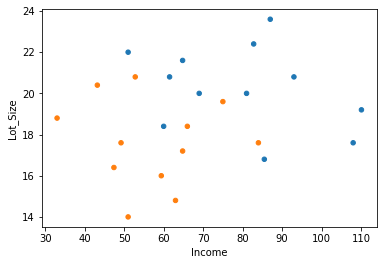

In [49]:
rm2 = pd.get_dummies(rm['Ownership'])
rm.plot.scatter(x='Income', y='Lot_Size', color=['C0' if color == 1 else 'C1'for color in rm2.Owner])

In [50]:
rm['Ownership'] = rm['Ownership'].astype('category')
rm = pd.get_dummies(rm, columns=['Ownership'], drop_first = True) # 1은 소유 0은 비소유

In [51]:
rm_Y=rm[rm['Ownership_Owner']==1]
rm_N=rm[rm['Ownership_Owner']==0]
print('평균소득 :  ', rm.Income.mean())
print("소유자의 소득 :  ", rm_Y.Income.mean())
print("비소유자의 소득 :  ",rm_N.Income.mean())

평균소득 :   68.4375
소유자의 소득 :   79.475
비소유자의 소득 :   57.4


소유자가 더 높게 갖는다

#### c

In [52]:
rm.head(5)

,Income,Lot_Size,Ownership_Owner
0,60.0,18.4,1
1,85.5,16.8,1
2,64.8,21.6,1
3,61.5,20.8,1
4,87.0,23.6,1


In [53]:
X = rm.drop(columns=["Ownership_Owner"])
y = rm["Ownership_Owner"]

logit_reg = LogisticRegression(penalty="l2", C=1e42, solver="liblinear")
logit_reg.fit(X, y)

print('intercept', logit_reg.intercept_[0])
print(pd.DataFrame({'coef': logit_reg.coef_[0]}, index=X.columns.transpose()))

intercept -25.870471875172292
              coef
Income    0.110611
Lot_Size  0.961144


In [54]:
classificationSummary(y, logit_reg.predict(X))

Confusion Matrix (Accuracy 0.8333)

       Prediction
Actual  0  1
     0 10  2
     1  2 10


12명 중, 10명이 정확히 분류됐다 = 10/12

#### d

In [55]:
## 정확히 분류된 비율을 증가하기 위해 _ 5장 예측성능평가 참고 (p144)

컷오프 증가

#### e

In [56]:
b0=round(-25.870471875172292,4)
b1=round(0.110611,4) ## 소득 1만 달라 = 10 k
b2=round(0.961144,4) ## 크기
print(b0,'\t', b1,'\t', b2)

-25.8705 	 0.1106 	 0.9611


로짓: log__Odds = -25.8705 + 0.1106 *x1 + 0.9611*x2

오즈: Odds_Y_1=math.exp(log__Odds)

확률: p=Odds_Y_1/(Odds_Y_1+1)

In [57]:
로짓 = -25.8705 + 0.1106*60 + 0.9611*20
로짓 = round(로짓,4)

In [58]:
오즈=math.exp(로짓)
오즈

0.9875778004938814

#### f

In [59]:
확률=오즈/(오즈+1)
확률

0.4968750406894684

0.5를 넘지 않아 가구를 소유하고 있지 않다고 분류한다.

(넷쨋자리까지 표기한 경우인데 소수점 몇째자리에서 반올림을 하냐에 따라 0.5 근방으로 근삿값으로 표현해 나타날 것 같음
-> 미세한 차이로 미소유 or 소유로 분류 가능)

#### g

In [60]:
X = rm.drop(columns=["Ownership_Owner"])
y = rm["Ownership_Owner"]

In [61]:
## X=X[X['Lot_Size']==16]
## X

In [62]:
## 확률 p가 0.5보다 크면 소유한다.
## 로짓은 양수여야 한다.

로짓 = -25.8705 + 0.1106*X.Income + 0.9611*16
로짓 =round(로짓,4)
로짓.sort_index(ascending=True)

0    -3.8569
1    -1.0366
2    -3.3260
3    -3.6910
4    -0.8707
5     1.6842
6     1.4519
7    -1.3352
8    -2.8615
9    -0.2071
10   -4.8523
11   -1.5343
12   -2.1979
13   -4.6532
14   -3.3260
15   -5.7150
16   -1.2025
17   -5.0514
18   -3.9233
19   -3.1933
20   -5.2505
21   -6.8431
22   -4.8523
23   -3.5251
Name: Income, dtype: float64

In [63]:
X.sort_index(ascending=True).iloc[5:7] ## 양수값을 갖는 부분을 다 보임

,Income,Lot_Size
5,110.1,19.2
6,108.0,17.6


최소한의 소득은 108

In [64]:
### ????????? 질문

## 10.4 eBay.com 의 경쟁적인 경매

In [65]:
ebay =  pd.read_csv("eBayAuctions.csv")

In [66]:
ebay.dtypes

Category         object
currency         object
sellerRating      int64
Duration          int64
endDay           object
ClosePrice      float64
OpenPrice       float64
Competitive?      int64
dtype: object

In [67]:
ebay.Category.unique()

array(['Music/Movie/Game', 'Automotive', 'SportingGoods', 'Home/Garden',
       'Books', 'Collectibles', 'Business/Industrial', 'Toys/Hobbies',
       'Electronics', 'Computer', 'EverythingElse',
       'Clothing/Accessories', 'Coins/Stamps', 'Antique/Art/Craft',
       'Jewelry', 'Pottery/Glass', 'Health/Beauty', 'Photography'],
      dtype=object)

In [68]:
ebay.Category=ebay.Category.astype('category')
ebay.currency=ebay.currency.astype('category')
ebay.endDay=ebay.endDay.astype('category')
ebay.Duration=ebay.Duration.astype('category')

#### a

In [69]:
## 문제를 해결하기 어려워 채형님이 푸신 방법 참고

In [70]:
a_Category = ebay.groupby(["Category"])['Competitive?'].mean()
a_Category.sort_values(inplace=True, ascending=False)
a_Category=round(a_Category,2)
a_Category

Category
Photography             0.85
Electronics             0.80
SportingGoods           0.73
Business/Industrial     0.67
Computer                0.67
Home/Garden             0.66
Music/Movie/Game        0.60
Collectibles            0.58
Antique/Art/Craft       0.56
Toys/Hobbies            0.53
Clothing/Accessories    0.50
Books                   0.50
Jewelry                 0.37
Automotive              0.35
Pottery/Glass           0.35
Coins/Stamps            0.30
EverythingElse          0.24
Health/Beauty           0.17
Name: Competitive?, dtype: float64

In [71]:
a_Category=pd.cut(a_Category,4)
a_Category

Category
Photography              (0.68, 0.85]
Electronics              (0.68, 0.85]
SportingGoods            (0.68, 0.85]
Business/Industrial      (0.51, 0.68]
Computer                 (0.51, 0.68]
Home/Garden              (0.51, 0.68]
Music/Movie/Game         (0.51, 0.68]
Collectibles             (0.51, 0.68]
Antique/Art/Craft        (0.51, 0.68]
Toys/Hobbies             (0.51, 0.68]
Clothing/Accessories     (0.34, 0.51]
Books                    (0.34, 0.51]
Jewelry                  (0.34, 0.51]
Automotive               (0.34, 0.51]
Pottery/Glass            (0.34, 0.51]
Coins/Stamps            (0.169, 0.34]
EverythingElse          (0.169, 0.34]
Health/Beauty           (0.169, 0.34]
Name: Competitive?, dtype: category
Categories (4, interval[float64, right]): [(0.169, 0.34] < (0.34, 0.51] < (0.51, 0.68] < (0.68, 0.85]]

In [72]:
a_currency = ebay.groupby(["currency"])['Competitive?'].mean()
a_currency.sort_values(inplace=True, ascending=False)
round(a_currency,2)

currency
GBP    0.69
EUR    0.55
US     0.52
Name: Competitive?, dtype: float64

In [73]:
a_currency=pd.cut(a_currency,2)
a_currency

currency
GBP    (0.603, 0.687]
EUR    (0.519, 0.603]
US     (0.519, 0.603]
Name: Competitive?, dtype: category
Categories (2, interval[float64, right]): [(0.519, 0.603] < (0.603, 0.687]]

In [74]:
a_endDay = ebay.groupby(["endDay"])['Competitive?'].mean()
a_endDay=round(a_endDay,2)
a_endDay.sort_values(inplace=True, ascending=False)
a_endDay

endDay
Mon    0.67
Thu    0.60
Tue    0.53
Sun    0.49
Wed    0.48
Fri    0.47
Sat    0.43
Name: Competitive?, dtype: float64

In [75]:
a_endDay=pd.cut(a_endDay,3)
a_endDay

endDay
Mon    (0.59, 0.67]
Thu    (0.59, 0.67]
Tue    (0.51, 0.59]
Sun    (0.43, 0.51]
Wed    (0.43, 0.51]
Fri    (0.43, 0.51]
Sat    (0.43, 0.51]
Name: Competitive?, dtype: category
Categories (3, interval[float64, right]): [(0.43, 0.51] < (0.51, 0.59] < (0.59, 0.67]]

In [76]:
a_Duration = ebay.groupby(["Duration"])['Competitive?'].mean()
a_Duration.sort_values(inplace=True, ascending=False)
a_Duration=round(a_Duration,2)
a_Duration

Duration
5     0.69
10    0.54
1     0.52
7     0.49
3     0.45
Name: Competitive?, dtype: float64

In [77]:
a_Duration=pd.cut(a_Duration,3)
a_Duration

Duration
5     (0.61, 0.69]
10    (0.53, 0.61]
1     (0.45, 0.53]
7     (0.45, 0.53]
3     (0.45, 0.53]
Name: Competitive?, dtype: category
Categories (3, interval[float64, right]): [(0.45, 0.53] < (0.53, 0.61] < (0.61, 0.69]]

#### b

In [78]:
ebay_new = pd.DataFrame({
 "Category70" : [1 if d in ("Photograpy", "Electronics", "SportingGoods") else 0 for d in ebay.Category],
 "Category50" : [1 if d in ("Business/Industrial", "Computer", "Home/Garden", "Music/Movie/Game", "Collectibles",
                            'Antique/Art/Craft', 'Toys/Hobbies', 'Clothing/Accessories','Books')
                else 0 for d in ebay.Category],                                                       
 "Category0": [1 if d in ("Jewelry", "Automotive", "Poterry/Glass", "Coins/Staps", "EverythingElse", "Health/Beauty")
                else 0 for d in ebay.Category],                         
    
 "currency_GBP": [1 if d == "GBP" else 0 for d in ebay.currency],
    
 "sellerRating": ebay.sellerRating,
    
 "Duration_5": [1 if d == 5 else 0 for d in ebay.Duration], # 두 그룹으로 분류
    
 "endDay_Mon_Tue": [1 if d in ('Mon', "Thu") else 0 for d in ebay.endDay], # 두 그룹으로 분류
 "ClosePrice": ebay.ClosePrice,
 "OpenPrice": ebay.OpenPrice,
 "Competitive": ebay['Competitive?']
})
ebay_new

,Category70,Category50,Category0,currency_GBP,sellerRating,Duration_5,endDay_Mon_Tue,ClosePrice,OpenPrice,Competitive
0,0,1,0,0,3249,1,1,0.01,0.01,0
1,0,1,0,0,3249,1,1,0.01,0.01,0
2,0,1,0,0,3249,1,1,0.01,0.01,0
3,0,1,0,0,3249,1,1,0.01,0.01,0
4,0,1,0,0,3249,1,1,0.01,0.01,0
...,...,...,...,...,...,...,...,...,...,...
1967,0,0,1,0,2992,1,0,359.95,359.95,0
1968,0,0,1,0,21,1,0,610.00,300.00,1
1969,0,0,1,0,1400,1,1,549.00,549.00,0
1970,0,0,1,0,57,0,0,820.00,650.00,1


In [79]:
ebay = ebay_new
ebay.dtypes ## 가변수 변환한 형태

Category70          int64
Category50          int64
Category0           int64
currency_GBP        int64
sellerRating        int64
Duration_5          int64
endDay_Mon_Tue      int64
ClosePrice        float64
OpenPrice         float64
Competitive         int64
dtype: object

In [80]:
X = ebay.drop(columns=["Competitive"])
y = ebay["Competitive"]

train_X, valid_X, train_y, valid_y = train_test_split(X, y, test_size=0.4, random_state=1)

logit_reg = LogisticRegression(penalty="l2", C=1e42, solver='liblinear')
logit_reg.fit(train_X, train_y)

print('intercept', logit_reg.intercept_[0])
print(pd.DataFrame({'coef': logit_reg.coef_[0]}, index=X.columns.transpose()))

intercept -1.2112757270881855
                    coef
Category70      0.707900
Category50      0.799400
Category0      -0.118287
currency_GBP    0.670079
sellerRating   -0.000023
Duration_5      0.624379
endDay_Mon_Tue  0.419607
ClosePrice      0.075190
OpenPrice      -0.087677


In [81]:
# 통계 모델의 상대적인 품질을 평가하는 것이다. AIC 값은 낮을수록 좋다

print('AIC', AIC_score(valid_y, logit_reg.predict(valid_X), df = len(train_X.columns) + 1))

AIC 1133.5887731316363


#### c

In [82]:
X = ebay.drop(columns=["Competitive","ClosePrice"])
y = ebay["Competitive"]

train_X, valid_X, train_y, valid_y = train_test_split(X, y, test_size=0.4, random_state=1)

logit_reg = LogisticRegression(penalty="l2", C=1e42, solver='liblinear')
logit_reg.fit(train_X, train_y)

print('intercept', logit_reg.intercept_[0])
print(pd.DataFrame({'coef': logit_reg.coef_[0]}, index=X.columns.transpose()))

intercept -0.27385280711892046
                    coef
Category70      1.245361
Category50      0.312967
Category0      -0.670193
currency_GBP    0.389203
sellerRating   -0.000032
Duration_5      0.572917
endDay_Mon_Tue  0.538501
OpenPrice      -0.003559


In [83]:
print('AIC', AIC_score(valid_y, logit_reg.predict(valid_X), df = len(train_X.columns) + 1))

AIC 1496.1347507533212


경매 종가가 포함된 모든 예측변수가 있는 모델이 더 좋은 성능을 갖고 있다.

#### d

양수이긴하나 값이 0.075190 으로 매우 작아

In [101]:
X = ebay.drop(columns=["Competitive"])
y = ebay["Competitive"]

train_X, valid_X, train_y, valid_y = train_test_split(X, y, test_size=0.4, random_state=1)

logit_reg = LogisticRegression(penalty="l2", C=1e42, solver='liblinear')
logit_reg.fit(train_X, train_y)

print('intercept', logit_reg.intercept_[0])
print(pd.DataFrame({'coef': logit_reg.coef_[0]}, index=X.columns.transpose()))

intercept -1.2112757270881855
                    coef
Category70      0.707900
Category50      0.799400
Category0      -0.118287
currency_GBP    0.670079
sellerRating   -0.000023
Duration_5      0.624379
endDay_Mon_Tue  0.419607
ClosePrice      0.075190
OpenPrice      -0.087677


In [85]:
import statsmodels.api as sm 
results = sm.OLS(y, sm.add_constant(X)).fit() 
results.summary()

C:\Users\ajm10\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            Competitive   R-squared:                       0.156
Model:                            OLS   Adj. R-squared:                  0.152
Method:                 Least Squares   F-statistic:                     40.21
Date:                Mon, 23 May 2022   Prob (F-statistic):           2.98e-66
Time:                        13:25:04   Log-Likelihood:                -1257.8
No. Observations:                1972   AIC:                             2536.
Df Residuals:                    1962   BIC:                             2592.
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const              0.2994      0.057      5.225      0.000       0.187       0.412
Category70         0.2956      0.067      4.431      0.000       0.165       0.426
Category50         0.1975      0.057      3.460      0.001       0.086       0.309
Category0         -0.0263      0.061     -0.431      0.666      -0.146       0.093
currency_GBP       0.1220      0.046      2.677      0.008       0.033       0.211
sellerRating    -7.42e-06   1.87e-06     -3.961      0.000   -1.11e-05   -3.75e-06
Duration_5         0.1460      0.028      5.216      0.000       0.091       0.201
endDay_Mon_Tue     0.0957      0.026      3.660      0.000       0.044       0.147
ClosePrice         0.0015      0.000     11.124      0.000       0.001       0.002
OpenPrice         -0.0022      0.000     -6.886      0.000      -0.003      -0.002
==============================================================================
Omnibus:                    10910.004   Durbin-Watson:                   0.774
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              205.335
Skew:                          -0.087   Prob(JB):                     2.58e-45
Kurtosis:                       1.429   Cond. No.                     7.66e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 7.66e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

#### e

In [86]:
import matplotlib.pylab as plt

from dmba import regressionSummary, exhaustive_search
from dmba import backward_elimination, forward_selection, stepwise_selection
from dmba import adjusted_r2_score, AIC_score, BIC_score

In [87]:
## 단계적 회귀 (6장 참고)

In [88]:
def train_model(variables):
    if len(variables) == 0:
        return None
    model = LogisticRegression(penalty="l2", C=1e42, solver='liblinear')
    model.fit(train_X[variables], train_y)
    return model

def score_model(model, variables):
    if len(variables) == 0:
        return AIC_score(train_y, [train_y.mean()] * len(train_y), model, df=1)
    return AIC_score(train_y, model.predict(train_X[variables]), model)

In [89]:
best_model, best_variables = stepwise_selection(train_X.columns, train_model, score_model, verbose=True)

print(best_variables)## 왜 안나오지

Variables: Category70, Category50, Category0, currency_GBP, sellerRating, Duration_5, endDay_Mon_Tue, ClosePrice, OpenPrice
Start: score=1716.20, constant
Step: score=1716.20, unchanged None
[]


In [90]:
## 전역탐색 
def train_model(variables):
    model = LogisticRegression(penalty="l2", C=1e42, solver='liblinear')
    model.fit(train_X[variables], train_y)
    return model

def score_model(model, variables):
    pred_y = model.predict(train_X[variables])
    # we negate as score is optimized to be as low as possible
    return -adjusted_r2_score(train_y, pred_y, model)

allVariables = train_X.columns
results = exhaustive_search(allVariables, train_model, score_model)

data = []
for result in results:
    model = result['model']
    variables = result['variables']
    AIC = AIC_score(train_y, model.predict(train_X[variables]), model)
    
    d = {'n': result['n'], 'r2adj': -result['score'], 'AIC': AIC}
    d.update({var: var in result['variables'] for var in allVariables})
    data.append(d)
    
pd.set_option('display.width', 100)
print(pd.DataFrame(data, columns=('n', 'r2adj', 'AIC') + tuple(sorted(allVariables))))
pd.reset_option('display.width')

   n     r2adj          AIC  Category0  Category50  Category70  ClosePrice  Duration_5  OpenPrice  \
0  1 -0.563308  2245.767621      False       False       False        True       False      False   
1  2  0.062015  1641.460908      False       False       False        True       False       True   
2  3  0.221745  1420.619814      False        True       False        True       False       True   
3  4  0.245534  1383.894026      False        True       False        True       False       True   
4  5  0.255730  1367.798540      False        True        True        True       False       True   
5  6  0.245534  1383.894026       True        True        True        True       False       True   
6  7  0.126587  1557.083692       True        True        True        True       False       True   
7  8  0.024632  1687.694145       True       False        True        True        True       True   
8  9  0.048421  1658.482784       True        True        True        True        True     

In [91]:
# r^2의 값이 증가하다가 안정된 형태가 되는 순간이 적합한 모형 n=5인 경우

 Category0 Category70  Duration_5 currency_GBP sellerRating 

#### f

In [102]:
## 전역탐색 
def train_model(variables):
    model = LogisticRegression(penalty="l2", C=1e42, solver='liblinear')
    model.fit(valid_X[variables], valid_y)
    return model

def score_model(model, variables):
    pred_y = model.predict(train_X[variables])
    # we negate as score is optimized to be as low as possible
    return -adjusted_r2_score(train_y, pred_y, model)

allVariables = train_X.columns
results = exhaustive_search(allVariables, train_model, score_model)

data = []
for result in results:
    model = result['model']
    variables = result['variables']
    AIC = AIC_score(train_y, model.predict(train_X[variables]), model)
    
    d = {'n': result['n'], 'r2adj': -result['score'], 'AIC': AIC}
    d.update({var: var in result['variables'] for var in allVariables})
    data.append(d)
    
pd.set_option('display.width', 100)
print(pd.DataFrame(data, columns=('n', 'r2adj', 'AIC') + tuple(sorted(allVariables))))
pd.reset_option('display.width')

   n     r2adj          AIC  Category0  Category50  Category70  ClosePrice  Duration_5  OpenPrice  \
0  1 -0.590496  2266.164678      False       False       False        True       False      False   
1  2  0.211549  1436.016994      False       False       False        True       False       True   
2  3  0.306707  1283.862636      False       False       False        True       False       True   
3  4  0.354286  1199.756161      False        True       False        True       False       True   
4  5  0.357684  1193.513402      False        True        True        True       False       True   
5  6  0.354286  1199.756161       True        True        True        True       False       True   
6  7  0.286316  1318.154892       True        True        True        True       False       True   
7  8  0.248933  1378.553159       True        True        True        True       False       True   
8  9  0.150376  1524.414949       True        True        True        True        True     

#### g

In [93]:
X = ebay[["Category0", "Category70", "Duration_5", "currency_GBP","sellerRating"]]
y = ebay["Competitive"]

train_X, valid_X, train_y, valid_y = train_test_split(X, y, test_size=0.4, random_state=1)

logit_reg = LogisticRegression(penalty="l2", C=1e42, solver='liblinear')
logit_reg.fit(train_X, train_y)

print('intercept', logit_reg.intercept_[0])
print(pd.DataFrame({'coef': logit_reg.coef_[0]}, index=X.columns.transpose()))

intercept 0.07874868088594657
                  coef
Category0    -1.041525
Category70    0.897736
Duration_5    0.815472
currency_GBP  0.801772
sellerRating -0.000025


In [94]:
print('AIC', AIC_score(valid_y, logit_reg.predict(valid_X), df = len(train_X.columns) + 1))

AIC 1392.257210952708


#### h

가장 잘 적합하는 모델: Category50  Category70  ClosePrice OpenPrice sellerRating (n=5)

가장 잘 예측하는 모델: Category50  Category70  ClosePrice OpenPrice endDay_Mon_Tue (n=5)  AIC 기준 

두 모델은 다르다. 왜냐하면 잘 적합하기 위해서는 변수가 많을수록 적합하는데 유리할 것이고
잘 예측하려면 적합하되 학습데이터의 잡음까지 학습하면 안되므로 변수의 수가 잘 적합하는 모델보다는 적을 것이기 때문이다.


In [97]:
## 이 이후부터는 파이썬 교재 참고하여 문제풀이

#### i

#### j

낮은 컷오프 값을 사용해야 한다.

#### k

a번을 이용해 평균값이 가장 높을 때 경쟁적인 경매로 이어진다.
각 변수를 확인했을 때 어떤 값이 가장 평균이 확인한다.
